# Conceptual Questions
# 

## Conceptual Questions

#### Web pages change. Two ways a website change can break scraping are HTML structure changes (e.g., renamed tags or classes so selectors no longer work) and content delivery changes (e.g., content moved behind JavaScript or pagination altered). To detect problems, I would use simple checks like logging HTTP status codes and asserting expected row counts. To keep it replicable, I would fix package versions, save the raw scraped data, and document when and how the data were collected.

## Applied Exercises

In [16]:
import re
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
from scholarly import scholarly
import json

In [17]:
# Ten faculty members from PSU PLSC departmement 
faculty_list = [
    {"name": "Matt Golder", "url": "https://polisci.la.psu.edu/people/mrg19/", "scholar_id": "yPbxmSwAAAAJ"},
    {"name": "Sona N. Golder", "url": "https://polisci.la.psu.edu/people/sng11/", "scholar_id": "Cuz1fTcAAAAJ"},
    {"name": "Lee Ann Banaszak", "url": "https://polisci.la.psu.edu/people/lab14/", "scholar_id": "i_LM_yAAAAAJ"},
    {"name": "Bruce Desmarais", "url": "https://polisci.la.psu.edu/people/bbd5087/", "scholar_id": "fRM8IN4AAAAJ"},
    {"name": "Cyanne E. Loyle", "url": "https://polisci.la.psu.edu/people/cel5432/", "scholar_id": "IMUIrJMAAAAJ"},
    {"name": "Joseph Wright", "url": "https://polisci.la.psu.edu/people/jgw12/", "scholar_id": "DV5ECYgAAAAJ"},
    {"name": "Bumba Mukherjee", "url": "https://polisci.la.psu.edu/people/sxm73/", "scholar_id": "6sS40fEAAAAJ"},
    {"name": "Jared Edgerton", "url": "https://polisci.la.psu.edu/people/jared-edgerton/", "scholar_id": "LLcIlUkAAAAJ"},
    {"name": "Daniel Tavana", "url": "https://polisci.la.psu.edu/people/daniel-tavana/", "scholar_id": "j2a1_doAAAAJ"},
    {"name": "Xun Cao", "url": "https://polisci.la.psu.edu/people/xuc11/", "scholar_id": "w18ZmkEAAAAJ"},
    
]
scraped_profiles = []
all_citation_history = []
scholar_metrics = []

In [18]:
# scape research interests from department website. 
# scrape citation metrics from Google Scholar.
for person in faculty_list:
    name = person["name"]
    url = person["url"]
    sid = person["scholar_id"]
    resp = requests.get(url)
    tree = html.fromstring(resp.content)
    interest_nodes = tree.xpath(
        "//h2[normalize-space()='Areas of Interest']/following-sibling::ul[1]/li"
        " | //h2[normalize-space()='Research Interests']/following-sibling::ul[1]/li")
    interests_list = [n.text_content().strip() for n in interest_nodes] # extract text, remove extra whitespaces
    interests_str = "; ".join(interests_list) # join list into a single string
    scraped_profiles.append({
        "name": name,
        "interests": interests_str})
    profile = scholarly.fill(scholarly.search_author_id(sid))
    cites_per_year = profile.get("cites_per_year", {})
    temp_df = pd.DataFrame({
        "year": list(cites_per_year.keys()), 
        "cites": list(cites_per_year.values())
    })
    temp_df["name"] = name
    all_citation_history.append(temp_df)
    scholar_metrics.append({
        "name": name,
        "total_citations": profile.get("citedby", 0),
        "h_index": profile.get("hindex", 0) 
    })
    time.sleep(1) # pause for 1 second between iterations

In [19]:
# Combine results into single dataframes
citation_df = pd.concat(all_citation_history, ignore_index=True)
citation_df["year"] = citation_df["year"].astype(int)


## print(scraped_profiles) 

# save dataset as json files 
with open("scraped_profiles.json", "w", encoding="utf-8") as f:
    json.dump(scraped_profiles, f, indent=4)
citation_df.to_json("citation.json", orient="records", indent=4)


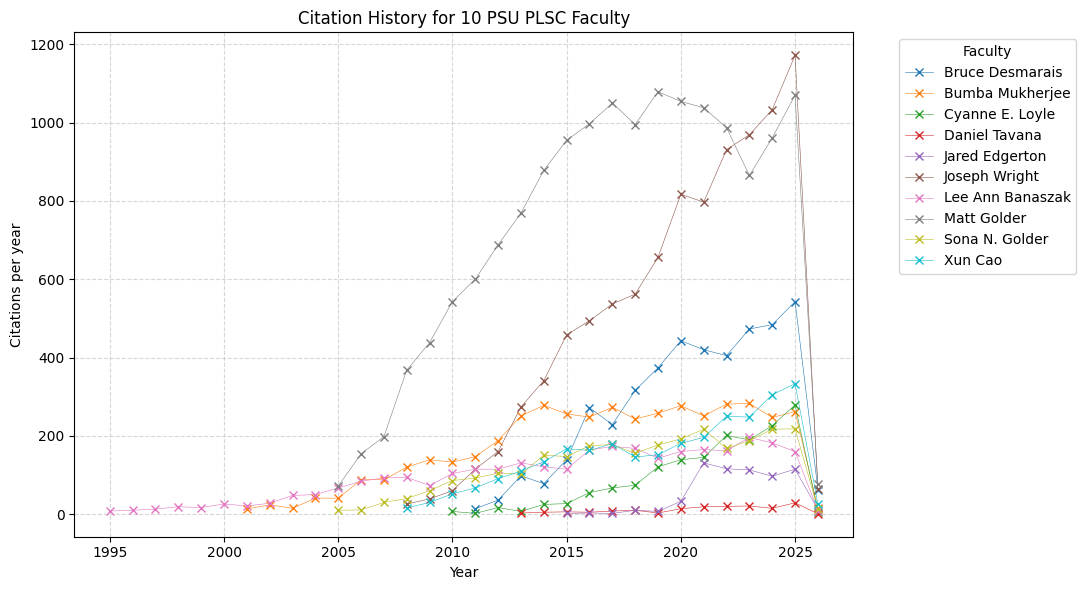

In [20]:
pivot_df = citation_df.pivot(index="year", columns="name", values="cites")
plt.figure(figsize=(11, 6))
pivot_df.plot(kind='line', marker='x', linewidth=0.4, ax=plt.gca())
plt.title("Citation History for 10 PSU PLSC Faculty")
plt.ylabel("Citations per year")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Faculty", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Plot1.png')
plt.show()

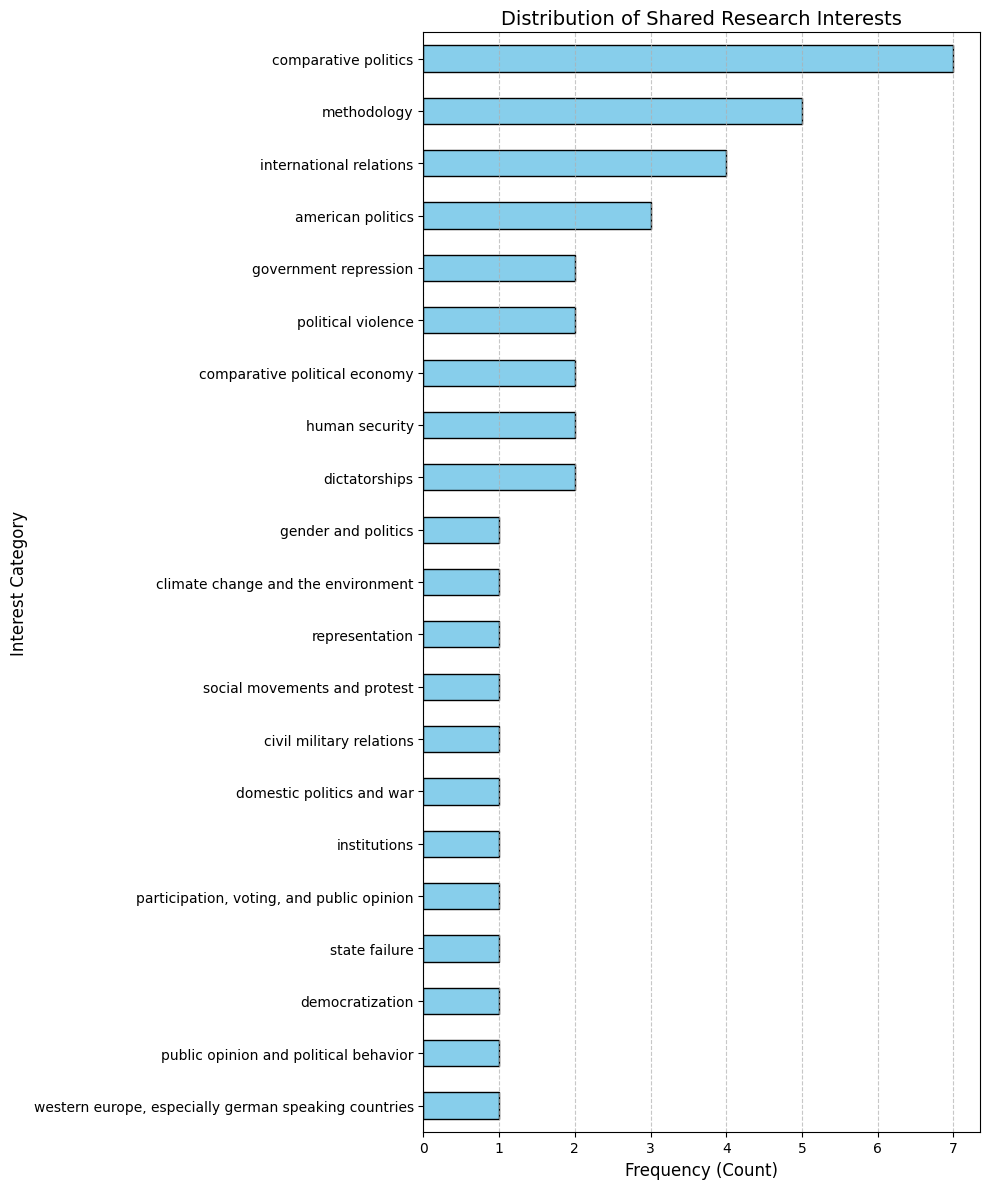

In [32]:
# Overlapped research interests 
all_interests = []
for p in scraped_profiles:
    split_interests = [i.strip().lower() for i in p["interests"].split(';')]
    all_interests.extend(split_interests)
kw_counts = pd.Series(all_interests).value_counts()

all_interests = []
for p in scraped_profiles:
    split_interests = [i.strip().lower() for i in p["interests"].split(';')]
    all_interests.extend(split_interests)
kw_counts = pd.Series(all_interests).value_counts()

plt.figure(figsize=(10, 12)) 
kw_counts.sort_values(ascending=True).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Distribution of Shared Research Interests', fontsize=14)
plt.xlabel('Frequency (Count)', fontsize=12)
plt.ylabel('Interest Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Plot2.png')
plt.show()

### Comparative politics, American politics, and methodology are top 3 shared research interests across 10 PLSC faculty members at Penn State.

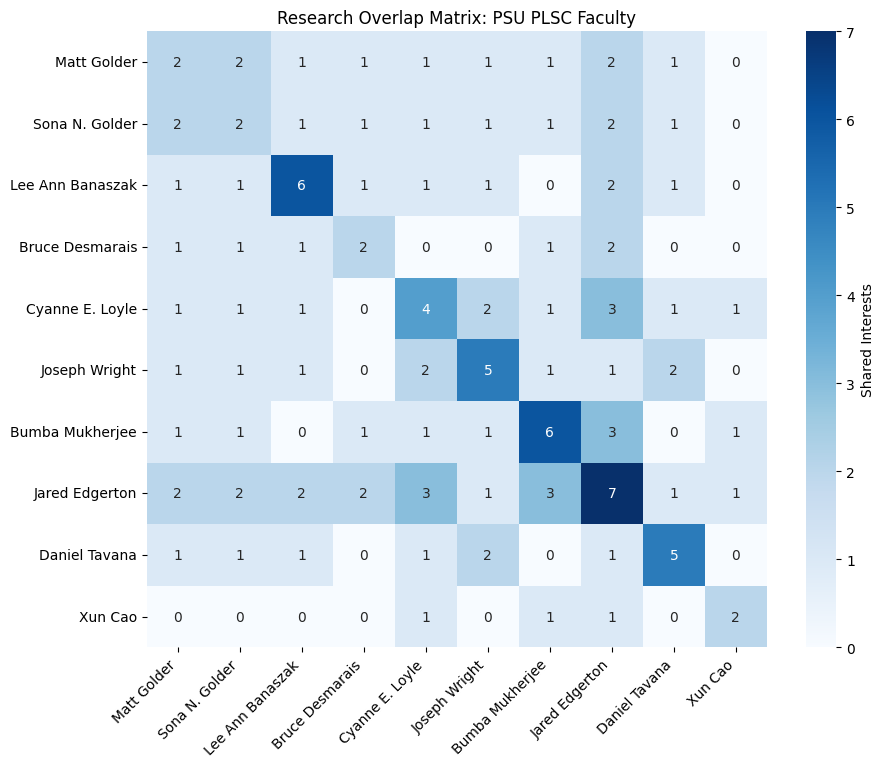

In [ ]:
# Overlap matrix and visualization

faculty_interests = {p['name']: set([i.strip().lower() for i in p['interests'].split(';')]) 
                    for p in scraped_profiles}

names = list(faculty_interests.keys())

matrix_data = []
for name1 in names:
    row = []
    for name2 in names:
        shared = len(faculty_interests[name1].intersection(faculty_interests[name2]))
        row.append(shared)
    matrix_data.append(row)

overlap_df = pd.DataFrame(matrix_data, index=names, columns=names)

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap="Blues", cbar_kws={'label': 'Shared Interests'})
plt.title('Research Overlap Matrix: PSU PLSC Faculty')
plt.xticks(rotation=45, ha='right')
plt.savefig('Plot3.png')
plt.show()

### Matt Golder and Sona N. Golder show a perfect overlap in Comparative Politics and Methodology.
### Bumba Mukherjee  and Jared Edgerton share three cross-field interests, including methodology, political violence, and international relations.
### Cyane Loyle and Jared Edgerton share three cross-filed interests, including government repression, international relations, and human security.

In [ ]:
# calculation based on observable years, where a scholar had at least one citation. 

median_cites = citation_df.groupby("name")["cites"].median().sort_values(ascending=False)
print(median_cites.to_string())


name
Matt Golder         871.5
Joseph Wright       494.0
Bruce Desmarais     294.0
Bumba Mukherjee     215.5
Xun Cao             152.0
Sona N. Golder      149.0
Lee Ann Banaszak     99.0
Cyanne E. Loyle      67.0
Jared Edgerton       22.5
Daniel Tavana         9.0
